In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch as ch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import random
import glob
from PIL import Image
from pandas.core.common import flatten
import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.insert(0, '/content/drive/MyDrive/Image_Synthesis')
import resnet

In [33]:
DATA_SHAPE=224
GRAIN=3.5
BATCH_SIZE = 5

In [4]:
# map imagenette to classes
class_name = {'tench': 'n01440764',
              'english springer': 'n02102040',
              'cassette player': 'n02979186',
              'chain saw': 'n03000684',
              'church': 'n03028079',
              'french horn': 'n03394916',
              'garbage truck': 'n03417042',
              'gas pump': 'n03425413',
              'golf ball': 'n03445777',
              'parachute': 'n03888257',  
}

In [5]:
# map imagenette to imagenet
class_ids = {0: 0,
              1: 217,
              2: 482,
              3: 491,
              4: 497,
              5: 566,
              6: 569,
              7: 571,
              8: 574,
              9: 701, }


In [6]:
imagenette_to_name = {0: 'tench',
                      1: 'english springer',
                      2: 'cassette player',
                      3: 'chain saw',
                      4: 'church',
                      5: 'french horn',
                      6: 'garbage truck',
                      7: 'gas pump',
                      8: 'golf ball',
                      9: 'parachute', }

In [ ]:
torch_model = torchvision.models.resnet50()
for k,v in torch_model.state_dict().items():
  print(k)



In [8]:
class InputNormalize(nn.Module):
    '''
    A module (custom layer) for normalizing the input to have a fixed 
    mean and standard deviation (user-specified).
    '''
    def __init__(self, new_mean, new_std):
        super(InputNormalize, self).__init__()
        new_std = new_std[..., None, None]
        new_mean = new_mean[..., None, None]

        self.register_buffer("new_mean", new_mean)
        self.register_buffer("new_std", new_std)

    def forward(self, x):
        x = ch.clamp(x, 0, 1)
        x_normalized = (x - self.new_mean)/self.new_std
        return x_normalized

In [9]:
class ModelNormalizer(nn.Module):
    def __init__(self, model, normalizer):
      super(ModelNormalizer, self).__init__()
      self.normalizer = normalizer
      self.model = model
    
    def forward(self, input):
      return self.model(self.normalizer(input))

# The normalizer is the normalizer the robustness github uses in the helpers class

In [10]:
mean = ch.tensor([0.485, 0.456, 0.406])
std = ch.tensor([0.229, 0.224, 0.225])

input_Normalize = InputNormalize(mean, std)
mod_resnet_model = ModelNormalizer(resnet.resnet50(), input_Normalize)

In [10]:
for k,v in mod_resnet_model.state_dict().items():
  print(k)

NameError: ignored

In [11]:
imagenet_pt = torch.load('/content/drive/MyDrive/Image_Synthesis/models/ImageNet.pt',
                         map_location=torch.device('cpu'))
cleaned_model = {}
for k,v in imagenet_pt['model'].items():
    if k.startswith('module.model'):
        k = k[7:]
        cleaned_model[k] = v
    elif k.startswith('module.normalizer'):
        k = k[7:]
        cleaned_model[k] = v
        # print(key)
        # normalizer_fields[key] = v

In [12]:
mod_resnet_model.load_state_dict(cleaned_model)

<All keys matched successfully>

In [ ]:
model = mod_resnet_model
model.eval()

Now make val folder load into test loader

In [34]:
test_image_paths = []
classes=[]
test_data_path = '/content/drive/MyDrive/Image_Synthesis/imagenette2/mini'
for data_path in sorted(glob.glob(test_data_path + '/*')):
    classes.append(data_path.split('/')[-1])
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

In [35]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [36]:
class ImagenetteDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = Image.open(image_filepath).convert("RGB")
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image)
        image = transforms.ToTensor()(image)
        
        return image, label

In [37]:
transform = transforms.Resize((224,224))
test_data = ImagenetteDataset(test_image_paths, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

Feature batch shape: torch.Size([5, 3, 224, 224])
Labels batch shape: torch.Size([5])


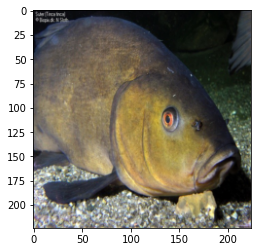

Label: 0


In [38]:
train_features, train_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
img = img.permute(1, 2, 0)
plt.imshow(img)
plt.show()
print(f"Label: {label}")

Define our Seed Distribution

In [39]:
im_test, targ_test = [], []
for _, (im, targ) in enumerate(test_dataloader):
    if _%10==0:
        print(_)
    im_test.append(im)
    targ_test.append(targ)
im_test, targ_test = torch.cat(im_test), torch.cat(targ_test)

0


In [40]:
print(targ_test)

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9,
        9, 9])


In [57]:
print(test_dataloader)

AttributeError: ignored

In [41]:
def downsample(x, step=GRAIN):
    down = ch.zeros([len(x), 3, DATA_SHAPE//step, DATA_SHAPE//step])

    for i in range(0, DATA_SHAPE, step):
        for j in range(0, DATA_SHAPE, step):
            v = x[:, :, i:i+step, j:j+step].mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
            ii, jj = i // step, j // step
            down[:, :, ii:ii+1, jj:jj+1] = v
    return down

def upsample(x, step=GRAIN):
    up = ch.zeros([len(x), 3, DATA_SHAPE, DATA_SHAPE])

    for i in range(0, DATA_SHAPE, step):
        for j in range(0, DATA_SHAPE, step):
            ii, jj = i // step, j // step
            up[:, :, i:i+step, j:j+step] = x[:, :, ii:ii+1, jj:jj+1]
    return up

torch.Size([224, 224, 3])


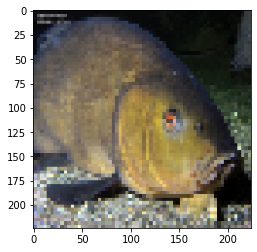

In [42]:
img = train_features.squeeze(0)

down_image = torch.nn.functional.interpolate(img, size=(64,64))
up_image = torch.nn.functional.interpolate(down_image, size=(224,224))

img = up_image[0].permute(1, 2, 0)
print(img.shape)
plt.imshow(img)
plt.show()
# down_image = downsample(img)
# up_image = upsample(down_image)
# plt.imshow(img)
# plt.show()

In [ ]:
# conditionals = []
# for i in tqdm(range(10)):
#     imc = im_test[targ_test == i]
#     down_flat = downsample(imc).view(len(imc), -1)
#     mean = down_flat.mean(dim=0)
#     down_flat = down_flat - mean.unsqueeze(dim=0)
#     cov = down_flat.t() @ down_flat / len(imc)
#     dist = MultivariateNormal(mean, covariance_matrix=cov+1e-4*ch.eye(3 * DATA_SHAPE//GRAIN * DATA_SHAPE//GRAIN))
#     conditionals.append(dist)

In [ ]:
# conditionals = torch.load('/content/drive/MyDrive/Image_Synthesis/MVDist.pt')

In [23]:
conditionals = torch.load('/content/drive/MyDrive/Image_Synthesis/NormDist.pt')

In [ ]:
# conditionals = torch.rand((10, 3, 224, 224))

In [43]:
def get_axis(axarr, H, W, i, j):
    H, W = H - 1, W - 1
    if not (H or W):
        ax = axarr
    elif not (H and W):
        ax = axarr[max(i, j)]
    else:
        ax = axarr[i][j]
    return ax

In [44]:
def show_image_row(xlist, ylist=None, fontsize=12, size=(2.5, 2.5), tlist=None, filename=None):
    H, W = len(xlist), len(xlist[0])
    fig, axarr = plt.subplots(H, W, figsize=(size[0] * W, size[1] * H))
    for w in range(W):
        for h in range(H):
            ax = get_axis(axarr, H, W, h, w)                
            ax.imshow(xlist[h][w].permute(1, 2, 0))
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
            ax.xaxis.set_ticklabels([])
            ax.yaxis.set_ticklabels([])
            if ylist and w == 0: 
                ax.set_ylabel(ylist[h], fontsize=fontsize)
            if tlist:
                ax.set_title(tlist[h][w], fontsize=fontsize)
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

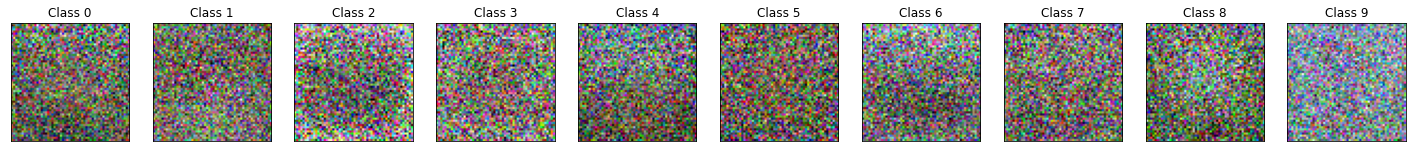

In [ ]:
# Visualize seeds
img_seed = ch.stack([conditionals[i].sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN) 
                     for i in range(10)])
img_seed = ch.clamp(img_seed, min=0, max=1)
show_image_row([img_seed.cpu()], tlist=[[f'Class {i}' for i in range(10)]])

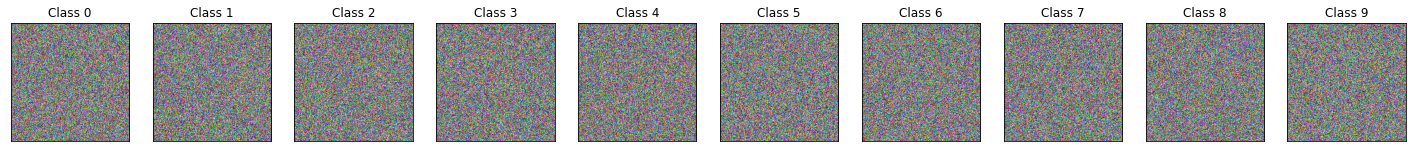

In [ ]:
# img_seed = ch.stack([conditionals[i] 
#                      for i in range(10)])
# img_seed = ch.clamp(img_seed, min=0, max=1)
# show_image_row([img_seed.cpu()], tlist=[[f'Class {i}' for i in range(10)]])

In [ ]:
print(img_seed.size())

In [45]:
# Compute the gradient of the loss w.r.t. the input data
def gradient_wrt_data(model,device,data,lbl, loss_list, num_im):
    dat = data.clone().detach()
    dat.requires_grad = True
    out = model(dat)
    loss = F.cross_entropy(out,lbl)
    model.zero_grad()
    loss.backward()
    loss_list.append(loss.item()/num_im)
    data_grad = dat.grad.data
    return data_grad.data.detach(), loss_list

def super_resolution(model, device, dat, lbl, eps, alpha, iters, up_samp, loss_list, iter_list, num_im):
    # TODO: Implement the PGD attack
    # - dat and lbl are tensors
    # - eps and alpha are floats
    # - iters is an integer

    # x_nat is the natural (clean) data batch, we .clone().detach()
    # to copy it and detach it from our computational graph
    x_nat = dat.clone().detach()

    # If rand_start is True, add uniform noise to the sample within [-eps,+eps],
    # else just copy x_nat
    # if rand_start == True:
    #   x_nat_clone = x_nat + torch.FloatTensor(x_nat.shape).uniform_(-eps, eps).to(device)
    # else:
    #   x_nat_clone = x_nat

    # Make sure the sample is projected into original distribution bounds [0,1]
    x_nat_clone = torch.clamp(x_nat.clone().detach(), 0., 1.)
    # x_nat_clone = x_nat

    # Iterate over iters
    for iter in range(iters):
      iter_list.append(iter)

        # Compute gradient w.r.t. data (we give you this function, but understand it)
      gradient, loss_list = gradient_wrt_data(model, device, x_nat_clone, lbl, loss_list, num_im)
      # gradient = generation_loss(model, x_nat_clone, lbl)
      # gradient_flatten = gradient.view(gradient.shape[0],-1)
      # l2_of_grad = torch.norm(gradient_flatten, p=2, dim=1)
      # l2_of_grad = torch.clamp(l2_of_grad, min=1e-12)
      # norm_grad = gradient/l2_of_grad
      l = len(x_nat.shape) - 1
      g_norm = torch.norm(gradient.view(gradient.shape[0], -1), dim=1).view(-1, *([1]*l))
      norm_grad = gradient / (g_norm + 1e-10)
        # Perturb the image using the gradient
      x_nat_clone = x_nat_clone - (alpha * norm_grad)
        # Clip the perturbed datapoints to ensure we still satisfy L_infinity constraint
                  #projection step
      diff = x_nat_clone - x_nat
      diff = diff.renorm(p=2, dim=0, maxnorm=eps)
      x_nat_clone = torch.clamp(x_nat.clone().detach() + diff.clone().detach(), 0., 1.)

        # Clip the perturbed datapoints to ensure we are in bounds [0,1]
      # x_nat_clone = torch.clamp(x_nat_clone.clone().detach(), 0, 1)

    # Return the final perturbed samples
    return x_nat_clone, loss_list, iter_list


device: cuda
tensor([0])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


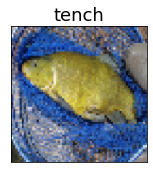

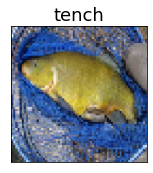

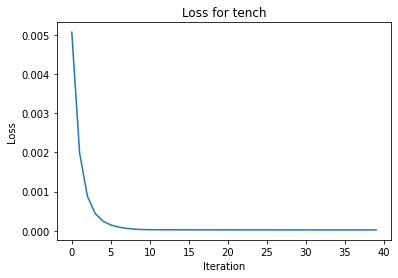

tensor([1])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


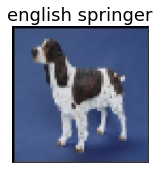

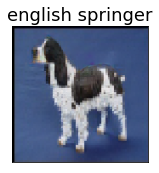

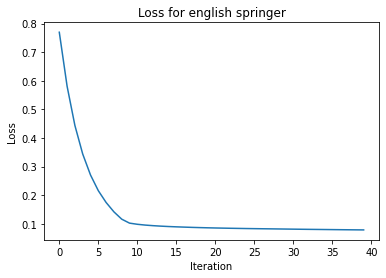

tensor([2])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


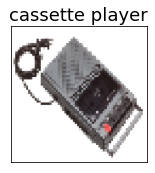

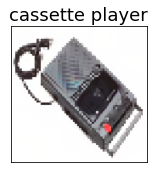

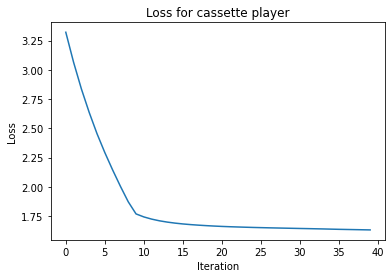

tensor([3])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


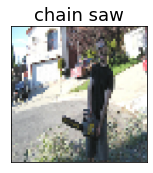

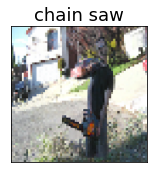

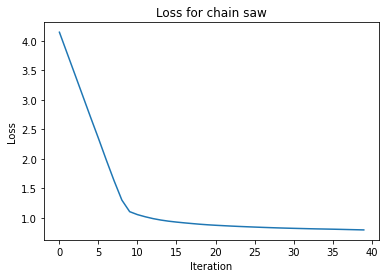

tensor([4])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


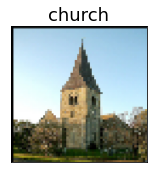

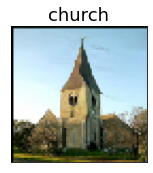

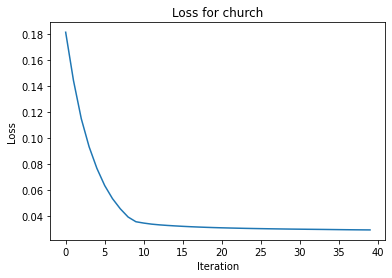

tensor([5])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


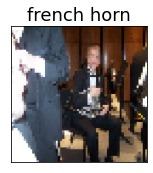

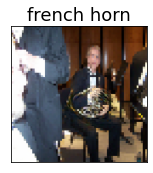

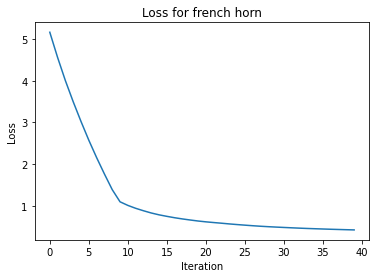

tensor([6])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


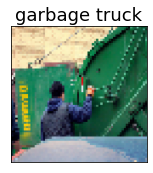

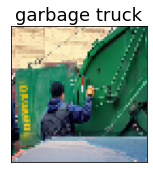

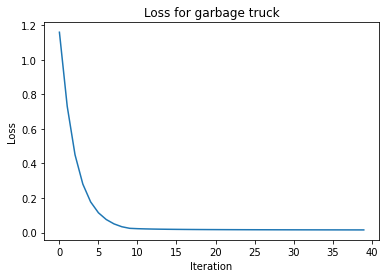

tensor([7])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


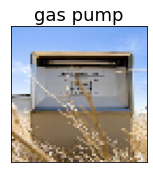

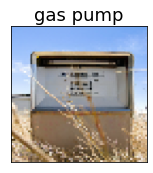

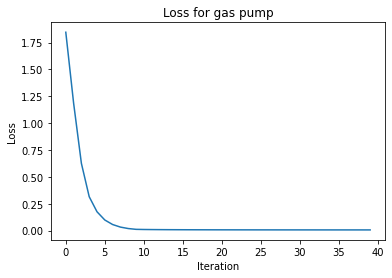

tensor([8])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


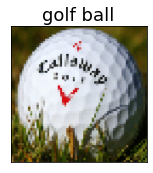

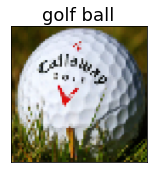

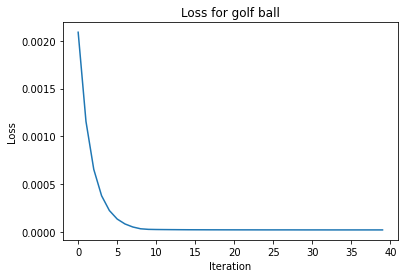

tensor([9])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


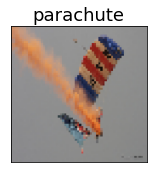

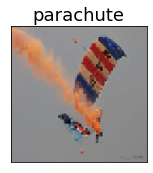

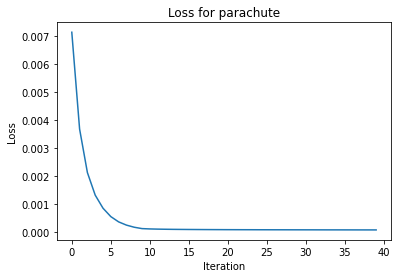

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)
show_seed = False
data_iterator = iter(test_dataloader)
for i in range(10):
    loss_list=[]
    iter_list=[]
    target_to_imgnet=[]
    target_class = ch.tensor([i])
    print(target_class)
    # im_seed = ch.stack([conditionals[int(t)].sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN) 
    #                     for t in target_class])
    # im_seed = ch.stack([conditionals[int(t)]
    #                     for t in target_class])

    for t in target_class:
        target_to_imgnet.append(class_ids[t.item()])
    target_class_adj = torch.tensor(target_to_imgnet)

    train_features, train_labels = next(data_iterator)
    # orig_image = im_test[targ_test == i]
    # orig_image = orig_image[random.randrange(200)]
    # orig_image = torch.tensor(orig_image)
    rand = random.randrange(5)
    orig_image = train_features[rand].unsqueeze(0)
    print(orig_image.shape)

    down_image = torch.nn.functional.interpolate(orig_image, size=(64,64))
    up_image = torch.nn.functional.interpolate(down_image, size=(224,224))
    up_image = up_image[0].unsqueeze(0)
    print(up_image.shape)
    

    EPS = 8
    ITS = 40
    ALP = 1
    UP_SAMPLE = 8
    # im_seed = torch.rand((5, 3, 224, 224))
    adv_data, loss_list, iter_list = super_resolution(model, device, up_image, 
                                                      target_class_adj.long(), EPS, ALP, ITS, UP_SAMPLE,
                                                      loss_list=loss_list, iter_list=iter_list, num_im=1)
    # print(target_class)
    show_image_row([up_image.detach().cpu()], 
                   tlist=[[imagenette_to_name[int(t)] for t in target_class]], 
                   fontsize=18)
    show_image_row([adv_data.detach().cpu()], 
                   tlist=[[imagenette_to_name[int(t)] for t in target_class]], 
                   fontsize=18)

    plt.plot(iter_list, loss_list)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss for {}'.format(imagenette_to_name[int(t)]))
    plt.show()
    # print(target_class.long().size(), im_seed.size())

# im_seed = torch.stack([conditionals[0].sample().view(3, DATA_SHAPE//GRAIN, DATA_SHAPE//GRAIN)])
# im_seed = upsample(ch.clamp(im_seed, min=0, max=1))
# target_class = 0*torch.ones((1,))
# EPS = 40
# ITS= 60
# ALP = 1
# adv_data = PGD_attack(model, device, im_seed, target_class.long(), EPS, ALP, ITS, rand_start=False)

In [ ]:
# with torch.no_grad():
#             clean_outputs = model(im_seed)
#             _,clean_preds = clean_outputs.max(1)
#             clean_preds = clean_preds.cpu().squeeze().numpy()
#             adv_outputs = model(adv_data)
#             _,adv_preds = adv_outputs.max(1)
#             adv_preds = adv_preds.cpu().squeeze().numpy()

In [ ]:
# img = adv_data[0].squeeze()
# img = img.permute(1, 2, 0)
# plt.imshow(img)